In [2]:
import numpy as np 
import matplotlib.pylab as plt 
import pandas as pd
import collections
from numpy import unravel_index
plt.rcParams['figure.facecolor'] = 'white'
sizetitle = 22
ticksize = 20
params = {'font.family':'sans-serif','font.sans-serif':'PT Sans','legend.fontsize': 13,'legend.handlelength': 2,'axes.labelsize':18, 'xtick.labelsize': ticksize, 'ytick.labelsize': ticksize,'figure.constrained_layout.use': True}
plt.rcParams.update(params)


In [3]:
#clase para el joint spectrum a una longitud de onda y a una temperatura 
class archiv:    
        
    def __init__(self,nombre,wll,T):
        self.archivo= pd.read_csv('{}'.format(nombre), sep='\t', engine='python') #carga el archivo
        self.wll=wll #la longitud de onda de la toma
        self.T=T #la temperatura de la toma 
        self.actualizar() #actualiza los datos de cada archivo 
        self.new_c = self.c_ambas[self.wl_signal>=800][self.wl_idler>=800] #selecciona todos los datos desde el mismo punto
    
    #Actiualiza los datos para cada variable del archivo 
    def actualizar(self):
        self.wl_signal=self.archivo['PosMasterTh (nm)']
        self.wl_idler=self.archivo['PosSlave (nm)']
        self.c_signal=self.archivo['CountsA (/s)']
        self.c_idler=self.archivo['CountsB (/s)']
        self.c_ambas=self.archivo['CoincAB (/s)']
        self.integ=self.archivo['Integration Time: 1.000000 (/s)']
    
    #Retorna las variables dada una condicion 
    def cual_Es(self,cual):
        if cual == 'signal':
            return [self.wl_signal,self.c_signal,'PosMasterTh (nm)']
        elif cual == 'idler':
            return [self.wl_idler,self.c_idler,'PosSlave (nm)']
        else:
            raise NameError
    
    #Grafica los espectros del s y i en el subplot por parametro 
    def graficar(self, axi):
        ax,n=axi
        a = ['signal','idler']
        for cual in a:
            wl,c,name = self.cual_Es(cual)
            contador = sorted(collections.Counter(wl).items()) #organiza el espectro que se quiere medir 
            self.archivo=self.archivo.sort_values(by=[name]) 
            self.actualizar()
            wl,c,name = self.cual_Es(cual)
            maxi = max(c)
            mini = min(c)
            i = 0
            dicci = dict(contador.copy())
            for wvl, cant in dicci.items(): #saca el valor medio para esa longitud de onda 
                dicci[wvl]=(sum(c[i:cant+i])/cant - mini)/(maxi-mini)
                i+=cant

            ax.plot(dicci.keys(),dicci.values(),label=cual)

            wl_max = max(dicci,key=dicci.get)
            print(round(wl_max),wl_max)
            ax.plot(np.ones(10)*wl_max,np.linspace(0,1,10),'--',lw=1,label=r'$\lambda_{{{0}}}={1}\pm5$ nm'.format(cual,round(wl_max)))
        
        ax.plot(np.ones(10)*self.wll*2,np.linspace(0,1,10),'k--',lw=0.7,label=r'2$\lambda_p={}$ nm'.format(self.wll*2))
        ax.set_title('$\lambda_p=$ {} nm T=${}^oC$'.format(self.wll,self.T),fontsize=sizetitle)
        ax.set(xlabel=r'$\lambda$(nm)', ylabel=r'Intensity (a.u.)')
        ax.legend()
        ax.text(0.05, 0.95,'{}'.format(n), transform=ax.transAxes, fontsize=35, verticalalignment='top')
        ax.set_xlim([800,820])
    
    #Grafica el espectro de la lampara 
    def graficar_lampara(self, cual, ax): 
        wl,c,name = self.cual_Es(cual)
        contador = sorted(collections.Counter(wl).items())
        self.archivo=self.archivo.sort_values(by=[name])
        self.actualizar()
        wl,c,name = self.cual_Es(cual)
        maxi = max(c)
        mini = min(c)
        i = 0
        dicci = dict(contador.copy())
        for wvl, cant in dicci.items():
            dicci[wvl]=(sum(c[i:cant+i])/cant - mini)/(maxi-mini)
            i+=cant
        
        ax.plot(list(dicci.keys()),list(dicci.values()),label=cual)
        
        ax.set_title('Ar lamp'.format(cual),fontsize=sizetitle)
        ax.set(xlabel=r'$\lambda$(nm)', ylabel=r'Intensity (a.u.)')
        ax.legend()
    
    #Grafica el joint spectrum
    def grafica_coincidencias(self,axi):
        ax,n=axi
        self.archivo=self.archivo.sort_values(by=['PosMasterTh (nm)','PosSlave (nm)'])
        self.actualizar()
        
        new_s = self.wl_signal[self.wl_signal>=800][self.wl_idler>=800]
        new_i = self.wl_idler[self.wl_signal>=800][self.wl_idler>=800]
        new_c1 = self.new_c
        new_c = (new_c1 - minimos)/(maximos-minimos)
        print(sum(new_c1)/np.sqrt(len(new_c1)))
        dime = sorted(collections.Counter(new_s).items())[0][1]
        
        Wls=np.array(new_s).reshape((dime,dime))
        Wli=np.array(new_i).reshape((dime,dime))
        
        coinci = np.array(new_c).reshape((dime,dime))
        result = unravel_index(coinci.argmax(),coinci.shape)
        maxs = Wls[result[0],0]
        maxi = Wli[0,result[1]]
        
        a = ax.contourf(Wls, Wli, coinci,levels=np.linspace(0,1,500))
        ax.plot(np.ones(10)*self.wll*2,np.linspace(min(new_s),max(new_s),10),'w--')
        ax.plot(np.linspace(min(new_s),max(new_s),10),np.ones(10)*self.wll*2,'w--')
        ax.set_title('$\lambda_p=$ {}nm T=${}^oC$'.format(self.wll,self.T),fontsize=sizetitle)
        ax.set(xlabel=r'$\lambda_s$(nm)', ylabel=r'$\lambda_i$(nm)')
        ax.text(0.05, 0.95,r'{} max {}$\pm${} Hz at'.format(n,int(round(max(new_c1),-2)),int(round(np.sqrt(max(new_c1)),-2)))+'\n' + r'$\lambda_s={}\pm5$ nm and $\lambda_i={}\pm5$ nm'.format(round(maxs),round(maxi)), transform=ax.transAxes, fontsize=18, verticalalignment='top',color='white')
        
        ax.scatter([maxs],[maxi],s=200,marker='+',color='white')
        donde = 0.2
        #ax.annotate("({},{})", (maxs+donde, maxi+donde),color='black',fontsize=15)
        
        return a
    
    #Grafica las lineas del espectro de la lampara de argon 
    def la_arg(self,ax):
        Ar = [866.794,912.296,922.450,935.422,965.779,978.450]
        #,1047.005,1067.357,1107.887,1144.183,1148.811,1166.871,1171.949,1211.233,1213.974,1234.339]
        for i in Ar:
            ax.plot(np.ones(10)*i,np.linspace(0,4000000,10),'--',lw=1,label='{} nm'.format(round(i,3)))
        ax.legend()

812 811.5
808 808.5
810 809.5
809 809.0
810 810.0
809 809.0
810 809.5
809 809.0
84499.92857142857
417341.61904761905
338122.3333333333
224253.7380952381


<ipython-input-4-a764260b7d4e>:42: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace = 0.07)


810 810.5
808 808.5
810 810.0
808 808.0
63189.97619047619
38660.380952380954


<ipython-input-4-a764260b7d4e>:73: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace = 0.07)


<Figure size 432x288 with 0 Axes>

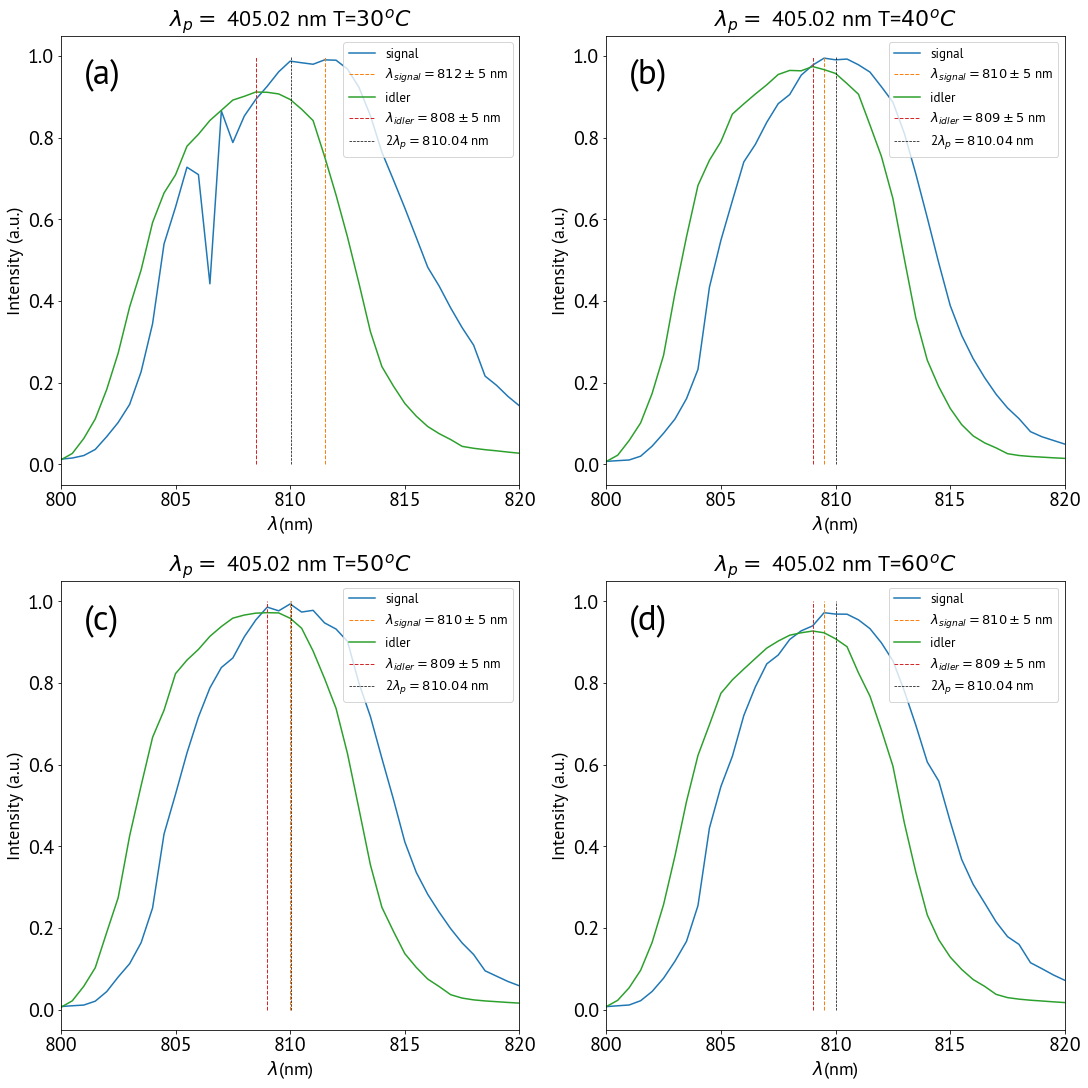

<Figure size 432x288 with 0 Axes>

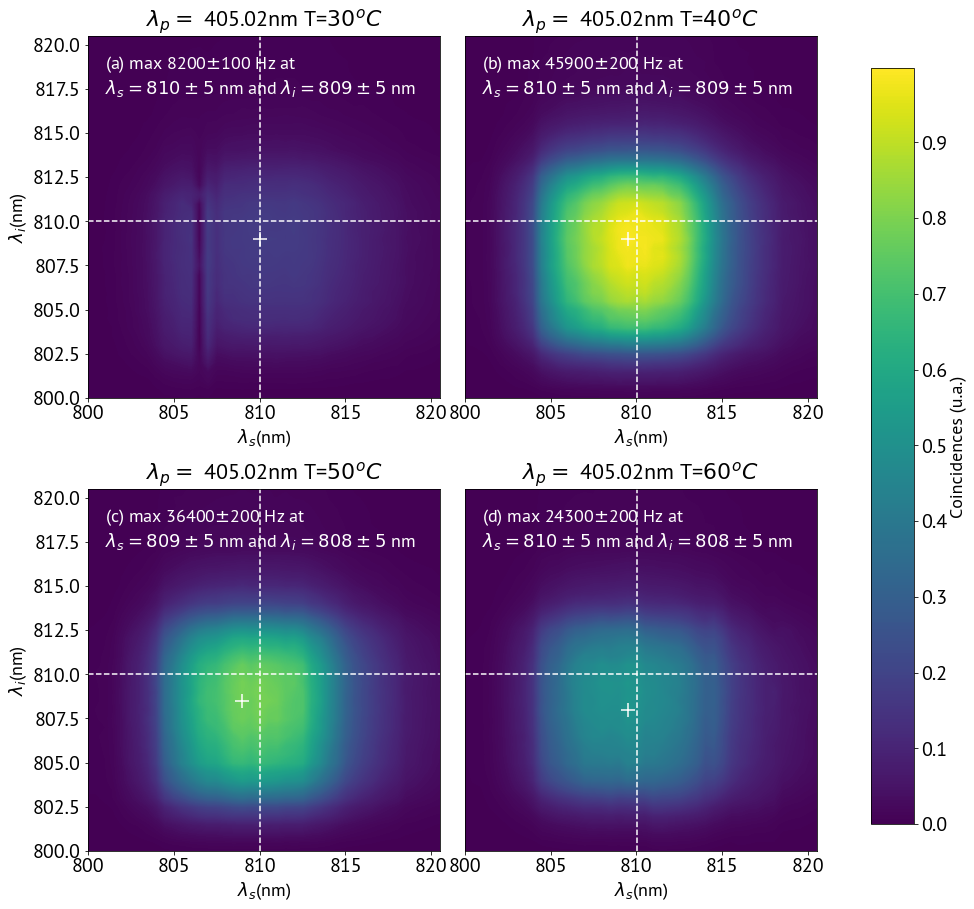

<Figure size 432x288 with 0 Axes>

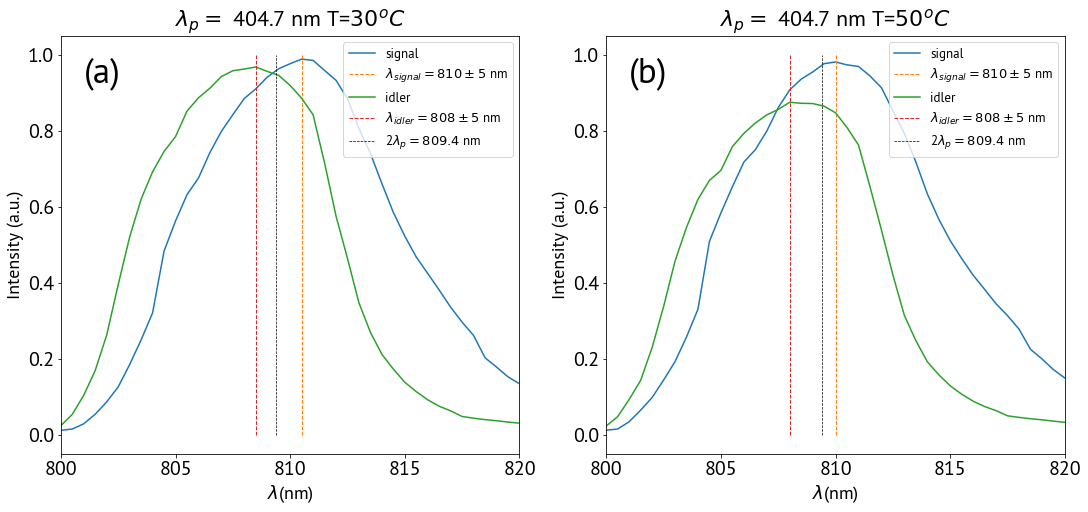

<Figure size 432x288 with 0 Axes>

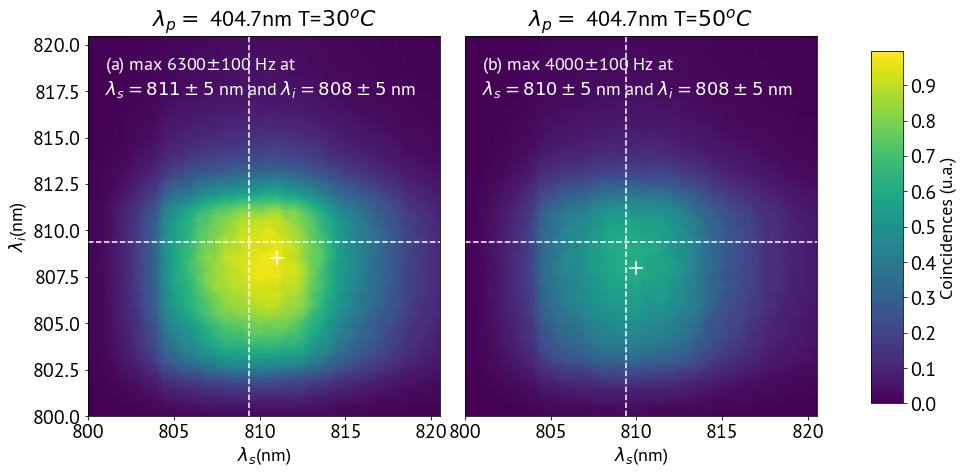

In [4]:
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(15,15))

wl = 405.02
entra = '/Users/mariamorris/Documents/Universidad/Monografía/Datos/21-Junio/'
sale = '/Users/mariamorris/Documents/Universidad/Monografía/Imágenes/Resultados/joint/'

#Crea los objetos de de cada wl y cada T 
WL405T30 = archiv(entra+'21 Junio/405.02 30C 230uW.txt',wl,30)
WL405T40 = archiv(entra+'21 Junio/405.02 40C.txt',wl,40)
WL405T50 = archiv(entra+'21 Junio/405.02 50C.txt',wl,50)
WL405T60 = archiv(entra+'21 Junio/405.02 60C.txt',wl,60)

#Grafica los espectros para cada condicion 
WL405T30.graficar([ax[0,0],'(a)'])
WL405T40.graficar([ax[0,1],'(b)'])
WL405T50.graficar([ax[1,0],'(c)'])
WL405T60.graficar([ax[1,1],'(d)'])
plt.savefig(sale+'WL405.png')

#Busca los maximos entre todos los datos 
rango = [WL405T30.new_c,WL405T40.new_c,WL405T50.new_c,WL405T60.new_c]
maximos = max([max(i) for i in rango])
minimos = min([min(i) for i in rango])

plt.figure()
fig2, ax2 = plt.subplots(2,2,figsize=(15,15))

#Ajusta las graficas 
plt.setp(ax2[0,1].get_yticklabels(), visible=False)
ax2[0,1].yaxis.set_visible(False)

plt.setp(ax2[1,1].get_yticklabels(), visible=False)
ax2[1,1].yaxis.set_visible(False)

#Grafica el joint spectrum para cada uno 
WL405T30.grafica_coincidencias([ax2[0,0],'(a)'])
im=WL405T40.grafica_coincidencias([ax2[0,1],'(b)'])
WL405T50.grafica_coincidencias([ax2[1,0],'(c)'])
WL405T60.grafica_coincidencias([ax2[1,1],'(d)'])

plt.subplots_adjust(wspace = 0.07)
plt.subplots_adjust(hspace = 0.25)

fig2.subplots_adjust(right=0.8)
cbar_ax = fig2.add_axes([0.85, 0.15, 0.04, 0.7])
fig2.colorbar(im, cax=cbar_ax,format='%.1f',label='Coincidences (u.a.)')
plt.savefig(sale+'WL405_coincidencias.png')

plt.figure()
fig, ax = plt.subplots(1,2,figsize=(15,7))

WL404T30 = archiv(entra+'21 Junio/404.7 30C 230uW.txt',404.7,30)
WL404T50 = archiv(entra+'21 Junio/404.7 50C 155uW.txt',404.7,50)

WL404T30.graficar([ax[0],'(a)'])
WL404T50.graficar([ax[1],'(b)'])

plt.savefig(sale+'WL404.png')

rango = [WL404T30.new_c,WL404T50.new_c]
maximos = max([max(i) for i in rango])
minimos = min([min(i) for i in rango])

plt.figure()
fig, ax = plt.subplots(1,2,figsize=(15,7))
plt.setp(ax[1].get_yticklabels(), visible=False)
ax[1].yaxis.set_visible(False)

im=WL404T30.grafica_coincidencias([ax[0],'(a)'])
WL404T50.grafica_coincidencias([ax[1],'(b)'])

plt.subplots_adjust(wspace = 0.07)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax,format='%.1f',label='Coincidences (u.a.)')
plt.savefig(sale+'WL404_otro.png')


417341.61904761905
338122.3333333333
224253.7380952381


<ipython-input-5-13ffe2fe4840>:18: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace = 0.065)


<Figure size 432x288 with 0 Axes>

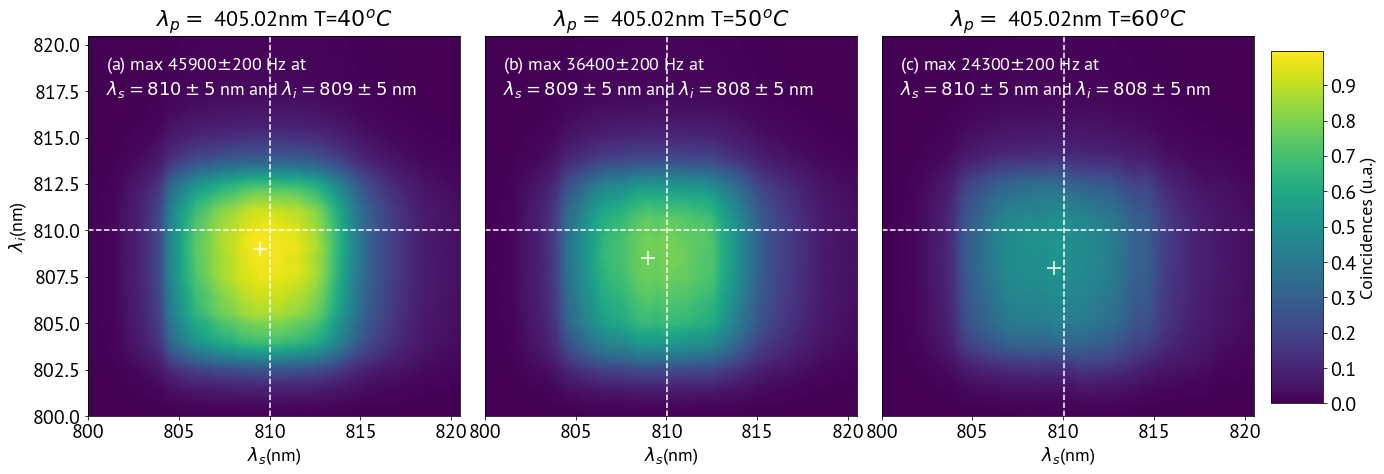

In [5]:
rango = [WL405T30.new_c,WL405T40.new_c,WL405T50.new_c,WL405T60.new_c]
maximos = max([max(i) for i in rango])
minimos = min([min(i) for i in rango])

plt.figure()
fig2, ax2 = plt.subplots(1,3,figsize=(24,7))

plt.setp(ax2[1].get_yticklabels(), visible=False)
ax2[1].yaxis.set_visible(False)

plt.setp(ax2[2].get_yticklabels(), visible=False)
ax2[2].yaxis.set_visible(False)

im=WL405T40.grafica_coincidencias([ax2[0],'(a)'])
WL405T50.grafica_coincidencias([ax2[1],'(b)'])
WL405T60.grafica_coincidencias([ax2[2],'(c)'])

plt.subplots_adjust(wspace = 0.065)
plt.subplots_adjust(hspace = 0.25)

fig2.subplots_adjust(right=0.8)
cbar_ax = fig2.add_axes([0.81, 0.15, 0.03, 0.7])
fig2.colorbar(im, cax=cbar_ax,format='%.1f',label='Coincidences (u.a.)')
plt.savefig(sale+'WL405_coincidencias3.png')

{867.033: 0.167,
 867.527: 0.179,
 867.774: 0.231,
 911.852: 0.187,
 912.098: 0.349,
 912.343: 0.651,
 912.589: 1.0,
 912.834: 0.892,
 913.079: 0.781,
 913.325: 0.466,
 913.57: 0.365,
 913.815: 0.221,
 914.061: 0.171,
 916.759: 0.169,
 922.397: 0.179,
 922.642: 0.291,
 922.887: 0.309,
 923.132: 0.229,
 923.377: 0.211,
 923.622: 0.191,
 923.867: 0.165,
 934.147: 0.169,
 966.106: 0.205,
 966.349: 0.259,
 966.593: 0.203,
 966.836: 0.213,
 979.961: 0.169}

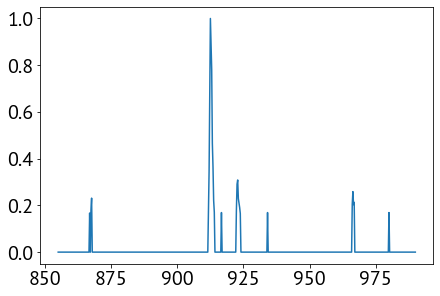

In [6]:
#archivo del ocean optics de espectro del argon
nombre = entra+'ESPECTRO.xlsx'
xls = pd.ExcelFile(nombre)
archivo = pd.read_excel(xls,decimal=',')

wl1 = 855
wl2 = 990
wl = archivo['CON1']
cont_con = (archivo['cont1_con']+archivo['cont2_con']+archivo['cont3_con'])/3
cont_sin = (archivo['cont1_sin']+archivo['cont2_sin']+archivo['cont3_sin'])/3
#cont_con[cont_con<0]=0
#cont_sin[cont_sin<0]=0
cont = cont_con #- cont_sin
cont = abs(cont[wl>=wl1][wl<=wl2])
wl = np.array(wl[wl>=wl1][wl<=wl2])
cont_norm = np.array((cont - min(cont))/(max(cont)-min(cont)))
cont_norm[cont_norm<0.164]=0
plt.plot(wl,cont_norm)
a = {round(wl[i],4):round(cont_norm[i],3) for i in range(len(cont_norm)) if cont_norm[i]!=0}
a

<Figure size 432x288 with 0 Axes>

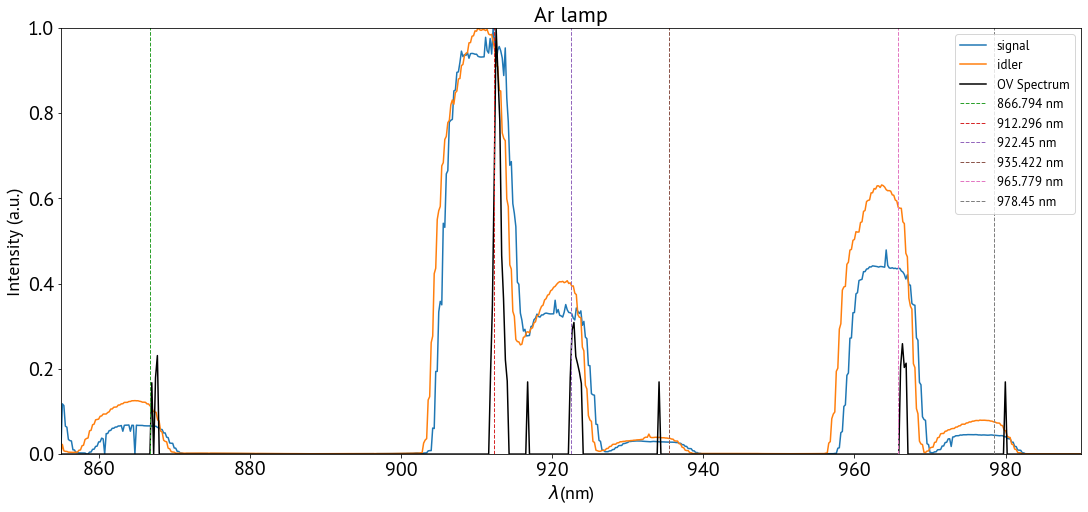

In [7]:
plt.figure()
fig3, ax3 = plt.subplots(1,figsize=(15,7))

argon_idler = archiv(entra+'21 Junio/argon idler.txt',1,1)
argon_signal = archiv(entra+'21 Junio/argon signal.txt',1,1)

argon_signal.graficar_lampara('signal',ax3)
argon_idler.graficar_lampara('idler',ax3)
plt.plot(wl,cont_norm,'k',label='OV Spectrum')
argon_idler.la_arg(ax3)
plt.xlim([wl1, wl2])
plt.ylim([0,1])
plt.savefig(sale+'argon_lamp.png')